ETS-ANN hybrid model for Bitcoin: Python 3.9.18

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from pycaret.utils import version
version()
from pycaret.time_series import TSForecastingExperiment
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima.utils import nsdiffs, ndiffs
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pycaret.time_series import *



Data pre-processing

1. Step given time series y

In [2]:
df_BTC = yf.download(
tickers = ["BTC-USD"],
start = "2020-01-01",
end = "2025-01-01"
)

df_BTC.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df_BTC.shape
df_BTC.info()
print('Null Values:',df_BTC.isnull().values.sum())
print(df_BTC.columns)
df_BTC.reset_index(inplace=True)
df_BTC['Date'] = pd.to_datetime(df_BTC['Date'], format='%Y-%m-%d')
df_BTC = df_BTC[['Date', 'Close']]
df_BTC.head()
df_BTC.set_index('Date', inplace=True)
print(df_BTC.index)
df_BTC = df_BTC.asfreq('D')  
print(f"Frequency of the index: {df_BTC.index.freq}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1827 non-null   float64
 1   High    1827 non-null   float64
 2   Low     1827 non-null   float64
 3   Open    1827 non-null   float64
 4   Volume  1827 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB
Null Values: 0
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=1827, freq=None)
Frequency of the ind

Setting up the Time Series Experiment for our data

In [3]:
exp_btc = TSForecastingExperiment()
exp_btc.setup(data=df_BTC, target='Close', fh=366, session_id=123,coverage=0.90)

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1827, 1)"
5,Transformed data shape,"(1827, 1)"
6,Transformed train set shape,"(1461, 1)"
7,Transformed test set shape,"(366, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


2. Split of the data into in sample and out sample, however were train test 

In [4]:
# Get the complete data
complete_data = exp_btc.get_config('y')

# Calculate the split indices
n_total = len(complete_data)
n_train = int(0.6 * n_total)
n_val = int(0.2 * n_total)
n_test = n_total - n_train - n_val

# Split the data
y_train_btc = complete_data[:n_train]
y_val_btc = complete_data[n_train:n_train + n_val]
y_test_btc = complete_data[n_train + n_val:]

# Print the start and end dates for each split to verify
print("Training Data (Start and End Dates):")
print(y_train_btc.head())
print(y_train_btc.tail())

print("\nValidation Data (Start and End Dates):")
print(y_val_btc.head())
print(y_val_btc.tail())

print("\nTesting Data (Start and End Dates):")
print(y_test_btc.head())
print(y_test_btc.tail())

Training Data (Start and End Dates):
Date
2020-01-01    7200.174316
2020-01-02    6985.470215
2020-01-03    7344.884277
2020-01-04    7410.656738
2020-01-05    7411.317383
Freq: D, Name: Close, dtype: float64
Date
2022-12-27    16717.173828
2022-12-28    16552.572266
2022-12-29    16642.341797
2022-12-30    16602.585938
2022-12-31    16547.496094
Freq: D, Name: Close, dtype: float64

Validation Data (Start and End Dates):
Date
2023-01-01    16625.080078
2023-01-02    16688.470703
2023-01-03    16679.857422
2023-01-04    16863.238281
2023-01-05    16836.736328
Freq: D, Name: Close, dtype: float64
Date
2023-12-27    43442.855469
2023-12-28    42627.855469
2023-12-29    42099.402344
2023-12-30    42156.902344
2023-12-31    42265.187500
Freq: D, Name: Close, dtype: float64

Testing Data (Start and End Dates):
Date
2024-01-01    44167.332031
2024-01-02    44957.968750
2024-01-03    42848.175781
2024-01-04    44179.921875
2024-01-05    44162.691406
Freq: D, Name: Close, dtype: float64
Date
2

In [5]:
# Concatenate training and validation data for in-sample data
in_sample_btc = pd.concat([y_train_btc, y_val_btc])
out_sample_btc = y_test_btc

print("\nin_sample_btc:")
print(in_sample_btc)

print("\nout_sample_btc:")
print(out_sample_btc)


in_sample_btc:
Date
2020-01-01     7200.174316
2020-01-02     6985.470215
2020-01-03     7344.884277
2020-01-04     7410.656738
2020-01-05     7411.317383
                  ...     
2023-12-27    43442.855469
2023-12-28    42627.855469
2023-12-29    42099.402344
2023-12-30    42156.902344
2023-12-31    42265.187500
Freq: D, Name: Close, Length: 1461, dtype: float64

out_sample_btc:
Date
2024-01-01    44167.332031
2024-01-02    44957.968750
2024-01-03    42848.175781
2024-01-04    44179.921875
2024-01-05    44162.691406
                  ...     
2024-12-27    94164.859375
2024-12-28    95163.929688
2024-12-29    93530.226562
2024-12-30    92643.210938
2024-12-31    93429.203125
Freq: D, Name: Close, Length: 366, dtype: float64


In [6]:
# Get and print all available configuration variables
config_vars = exp_btc.get_config()
print("Available configuration variables:")
print(config_vars)

# Check if 'X_train' is in the configuration and print its start and end dates if available
if 'X_train' in config_vars:
    setup_data = exp_btc.get_config('X_train')
    if setup_data is not None:
        print("Data used in the ETS model determinations:")
        print(f"Start Date: {setup_data.index.min()}")
        print(f"End Date: {setup_data.index.max()}")
    else:
        print("X_train is None.")
else:
    print("X_train is not available in the configuration.")

Available configuration variables:
{'test', 'enforce_exogenous', 'html_param', 'enforce_pi', 'seasonality_present', 'memory', '_available_plots', 'y', 'fh', 'X_train_transformed', 'data', 'USI', 'n_jobs_param', 'dataset', 'y_train_transformed', 'X_transformed', 'exp_name_log', 'candidate_sps', 'dataset_transformed', 'all_sps_to_use', 'variable_and_property_keys', 'significant_sps_no_harmonics', 'primary_sp_to_use', 'exogenous_present', 'X_test_transformed', 'variables', 'y_train', 'X_test', 'idx', 'X', 'index_type', 'approach_type', 'X_train', 'y_test', 'exp_id', '_ml_usecase', 'gpu_n_jobs_param', 'strictly_positive', 'fold_param', 'train', 'train_transformed', 'seed', 'logging_param', 'gpu_param', 'log_plots_param', 'pipeline', 'model_engines', 'y_test_transformed', 'y_transformed', 'fold_generator', 'is_multiclass', 'test_transformed', 'significant_sps'}
X_train is None.


Here I am making sure that from the PyCaret source code, the setup function and create_model function handled the data preparation and model training => whether the data used in the ETS determinations is trully the in-sample [train + validation]

In [7]:
# Setting up the Time Series Experiment
exp_btc = TSForecastingExperiment()
exp_btc.setup(data=df_BTC, target='Close', fh=366, session_id=123, coverage=0.90)

# Get the y_train data used in the experiment setup
setup_y_train = exp_btc.get_config('y_train')  # Get the training target data used in the setup

# Print the start and end dates of the y_train data
if setup_y_train is not None:
    print("Data used in the ETS model determinations:")
    print(f"Start Date: {setup_y_train.index.min()}")
    print(f"End Date: {setup_y_train.index.max()}")
else:
    print("y_train is None.")

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1827, 1)"
5,Transformed data shape,"(1827, 1)"
6,Transformed train set shape,"(1461, 1)"
7,Transformed test set shape,"(366, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Data used in the ETS model determinations:
Start Date: 2020-01-01
End Date: 2023-12-31


Available models for the experiment

In [8]:
exp_btc.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend._polynomial_trend_for...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
croston,Croston,sktime.forecasting.croston.Croston,True
ets,ETS,sktime.forecasting.ets.AutoETS,True


ETS model selection for the data

4. Determine the best ETS (E,T,S) using in-sample data

In [9]:
ses_btc = exp_btc.create_model('exp_smooth', trend=None, seasonal=None, sp= None, cross_validation=False )
ht_btc = exp_btc.create_model('exp_smooth', trend='add', seasonal=None, cross_validation=False)
#
hw_add_btc = exp_btc.create_model('exp_smooth', trend='add', seasonal='add', sp= 365, cross_validation=False)
hw_mult_btc = exp_btc.create_model('exp_smooth', trend='add', seasonal='mul', sp=365, cross_validation=False)
hw_damped_btc = exp_btc.create_model('exp_smooth', damped_trend='True' , trend='add', seasonal='mul', sp=365, cross_validation=False)
#
ets_ANN_btc = exp_btc.create_model('ets', error="add", trend=None, seasonal=None ,cross_validation=False ) # this is equivalent 
ets_AAN_btc = exp_btc.create_model('ets', error="add", trend="add", seasonal=None ,cross_validation=False ) # this is 
ets_AAM_btc = exp_btc.create_model('ets', error="add", trend="add", seasonal="mul" ,cross_validation=False )

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,10.4065,7.9579,23778.0662,27870.7850,0.3305,0.4127,-2.6130


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,3.9898,3.1633,9116.4496,11078.9280,0.1303,0.1378,0.4291


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,4.9294,4.3317,11263.4223,15170.8838,0.1520,0.1716,-0.0705


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,5.4553,4.7107,12464.9404,16498.1235,0.1723,0.1949,-0.2660


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,9.8562,7.9032,22520.6633,27679.1632,0.3128,0.3941,-2.5635


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,10.4066,7.9579,23778.3408,27871.0348,0.3305,0.4127,-2.6131


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,7.3447,5.8560,16782.1870,20509.3429,0.2304,0.2705,-0.9565


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,7.9004,6.2238,18051.8716,21797.4003,0.2485,0.2948,-1.2099


Comparing the models

In [10]:
exp_btc.compare_models(include=[ ses_btc, ht_btc, hw_add_btc, hw_mult_btc, hw_damped_btc, ets_ANN_btc, ets_AAN_btc, ets_AAM_btc, 'ets'], cross_validation=False)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
1,Exponential Smoothing,3.9898,3.1633,9116.4496,11078.9280,0.1303,0.1378,0.4291,0.0300
2,Exponential Smoothing,4.9294,4.3317,11263.4223,15170.8838,0.1520,0.1716,-0.0705,0.3500
3,Exponential Smoothing,5.4553,4.7107,12464.9404,16498.1235,0.1723,0.1949,-0.2660,0.7400
6,ETS,7.3447,5.8560,16782.1870,20509.3429,0.2304,0.2705,-0.9565,0.0400
7,ETS,7.9004,6.2238,18051.8716,21797.4003,0.2485,0.2948,-1.2099,0.0800
8,ETS,7.9004,6.2238,18051.8716,21797.4003,0.2485,0.2948,-1.2099,0.0800
4,Exponential Smoothing,9.8562,7.9032,22520.6633,27679.1632,0.3128,0.3941,-2.5635,0.9700
0,Exponential Smoothing,10.4065,7.9579,23778.0662,27870.7850,0.3305,0.4127,-2.6130,0.0100
5,ETS,10.4066,7.9579,23778.3408,27871.0348,0.3305,0.4127,-2.6131,0.0100


ExponentialSmoothing(sp=9, trend='add')

In [27]:

ets_auto_btc = exp_btc.create_model('ets', cross_validation=False)  # Auto ETS selection
tuned_ets_auto_btc = exp_btc.tune_model(ets_auto_btc)
exp_btc.compare_models(include=[ ht_btc, tuned_ets_auto_btc], cross_validation=False) # Compare tuned Auto-ETS 

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,7.9004,6.2238,18051.8716,21797.4003,0.2485,0.2948,-1.2099


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,"PeriodIndex(['2020-12-28'], dtype='period[D]', name='Date')",11.5688,9.3141,10146.3420,12121.4814,0.2179,0.2260,-0.4959
1,"PeriodIndex(['2021-12-29'], dtype='period[D]', name='Date')",6.1598,4.5998,16832.7174,19246.1955,0.7946,0.5055,-2.5303
2,"PeriodIndex(['2022-12-30'], dtype='period[D]', name='Date')",8.5207,6.2880,21690.5462,24233.4585,0.7107,1.1989,-15.7633
Mean,nan,8.7498,6.7340,16223.2019,18533.7118,0.5744,0.6435,-6.2632
SD,nan,2.2141,1.9503,4732.5676,4970.2932,0.2544,0.4090,6.7687


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.9s finished


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
0,Exponential Smoothing,3.9898,3.1633,9116.4496,11078.9280,0.1303,0.1378,0.4291,0.0400
1,ETS,6.5725,5.3494,15017.7588,18735.2391,0.2053,0.2381,-0.6326,0.0900


ExponentialSmoothing(sp=9, trend='add')

For our data ht_btc is the best model

In [28]:
# Debugging: Check the type and attributes of ht_btc
print(f"Type: {type(ht_btc)}")
print(f"Attributes and methods of ht_btc: {dir(ht_btc)}")

Type: <class 'sktime.forecasting.exp_smoothing.ExponentialSmoothing'>
Attributes and methods of ht_btc: ['_X', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rpow__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_alias_params', '_check_X', '_check_X_y', '_check_fh', '_clone_flags', '_components', '_config', '_config_doc', '_config_dynamic', '_converter_store_y', '_cutoff', '_extract_conf_int', '_fh', '_fit', '_fit_forecaster', '_fitted_forecaster', '_fitted_param_names', '_forecaster', '_get_class_flag', '_get_class_flags', '_get_columns', '_get_fitted_param_names', '_get_fitted_params', '_get_fitted_params_default', '_get_flag', '_get_flags', '_get_init_signature', '_ge

In-sample predictions

In [29]:

in_sample_predictions_ht_btc = ht_btc._fitted_forecaster.fittedvalues
in_sample_predictions_ht_btc.index = exp_btc.get_config('y_train').index
print("\nIn-sample predictions from (ht_btc):")
print(in_sample_predictions_ht_btc)


In-sample predictions from (ht_btc):
Date
2020-01-01     7061.694070
2020-01-02     7324.742793
2020-01-03     7127.515607
2020-01-04     7462.668005
2020-01-05     7541.346983
                  ...     
2023-12-27    42709.062304
2023-12-28    43545.551555
2023-12-29    42796.555445
2023-12-30    42241.325860
2023-12-31    42265.026416
Freq: D, Length: 1461, dtype: float64


Ensuring the indexs of in-sample predictions matches the training data

In [30]:
in_sample_predictions_ht_btc.index = exp_btc.get_config('y_train').index
print("\nIn-sample predictions from Holt Winter method (ht_btc):")
print(in_sample_predictions_ht_btc)
if exp_btc.get_config('y_train').index.equals(in_sample_predictions_ht_btc.index):
    print("\nIndices are ALIGNED!")
else:
    print("\nIndices are NOT aligned (Warning!)")


In-sample predictions from Holt Winter method (ht_btc):
Date
2020-01-01     7061.694070
2020-01-02     7324.742793
2020-01-03     7127.515607
2020-01-04     7462.668005
2020-01-05     7541.346983
                  ...     
2023-12-27    42709.062304
2023-12-28    43545.551555
2023-12-29    42796.555445
2023-12-30    42241.325860
2023-12-31    42265.026416
Freq: D, Length: 1461, dtype: float64

Indices are ALIGNED!


5. Obtain predictions using the selected ETS model

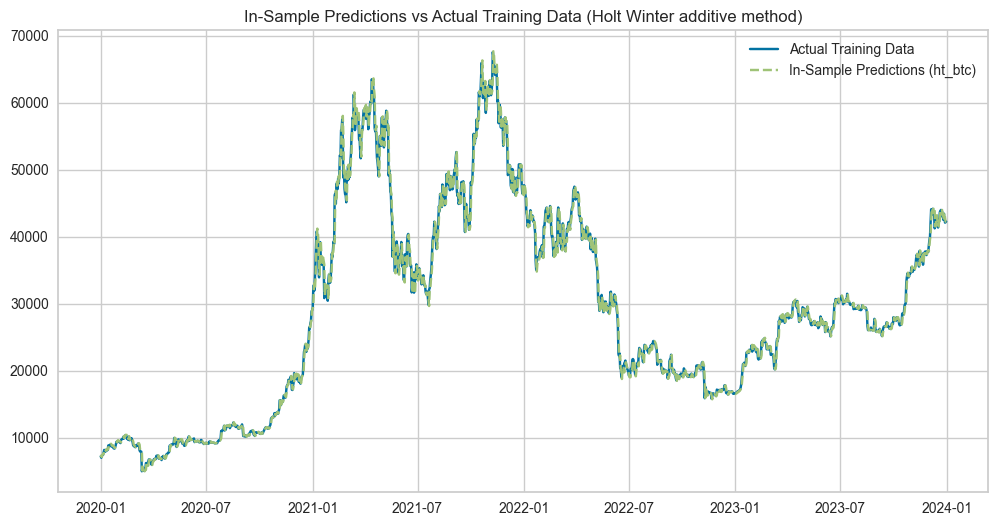

In [31]:
plt.figure(figsize=(12, 6))
actual_train_index_dt = exp_btc.get_config('y_train').index.to_timestamp()
prediction_index_dt = in_sample_predictions_ht_btc.index.to_timestamp()
plt.plot(actual_train_index_dt, exp_btc.get_config('y_train'), label='Actual Training Data')
plt.plot(prediction_index_dt, in_sample_predictions_ht_btc, label='In-Sample Predictions (ht_btc)', linestyle='--')
plt.title('In-Sample Predictions vs Actual Training Data (Holt Winter additive method)')
plt.legend()
plt.show()

Acquiring residuals

7. Obtain the residual series by subtracting ETS-predictions from the original series 

In [37]:
residuals = in_sample_btc - in_sample_predictions_ht_btc
print("\nFirst 10 residuals:")
print(residuals.head(10))



First 10 residuals:
Date
2020-01-01    138.480247
2020-01-02   -339.272578
2020-01-03    217.368670
2020-01-04    -52.011267
2020-01-05   -130.029600
2020-01-06    225.992851
2020-01-07    276.175986
2020-01-08   -205.561902
2020-01-09   -343.138527
2020-01-10    145.481445
Freq: D, dtype: float64


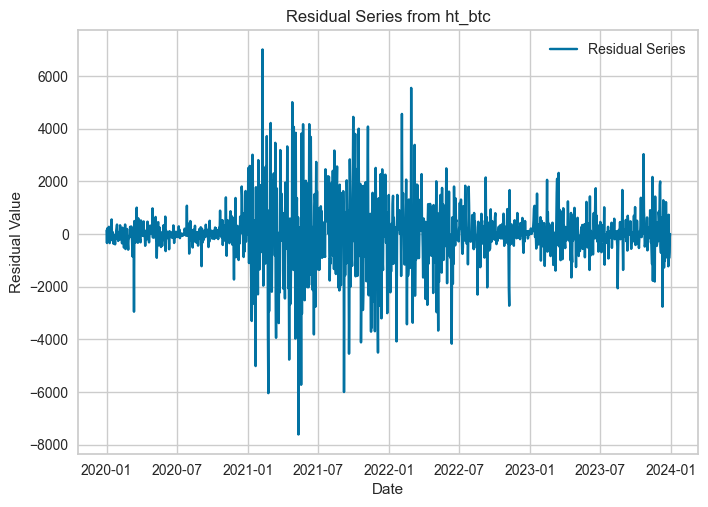

In [38]:
residuals_index_dt = residuals.index.to_timestamp()
plt.plot(residuals_index_dt, residuals, label='Residual Series')
plt.title('Residual Series from ht_btc')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

Performing visualization of the acf partial of step 8: "Perform lag selection using autocorrelation function on the in-sample data of residual series"

In [39]:
exp_btc.plot_model(plot='acf',  data_kwargs={'nlags': 50}) 


9: Normalize the residual series using min-max normalization considering the minimum and maximum value of in-sample residual

In [44]:
# Step 9: Normalized Residual Series (Min-Max Normalization)
scaler_residuals = MinMaxScaler(feature_range=(-1, 1))
normalized_residuals = scaler_residuals.fit_transform(residuals.values.reshape(-1, 1))
normalized_residuals = pd.Series(normalized_residuals.flatten(), index=residuals.index)

print("\nFirst 10 Normalized Residuals:")
print(normalized_residuals.head(10))


First 10 Normalized Residuals:
Date
2020-01-01    0.059940
2020-01-02   -0.005389
2020-01-03    0.070727
2020-01-04    0.033892
2020-01-05    0.023223
2020-01-06    0.071906
2020-01-07    0.078768
2020-01-08    0.012895
2020-01-09   -0.005917
2020-01-10    0.060897
Freq: D, dtype: float64


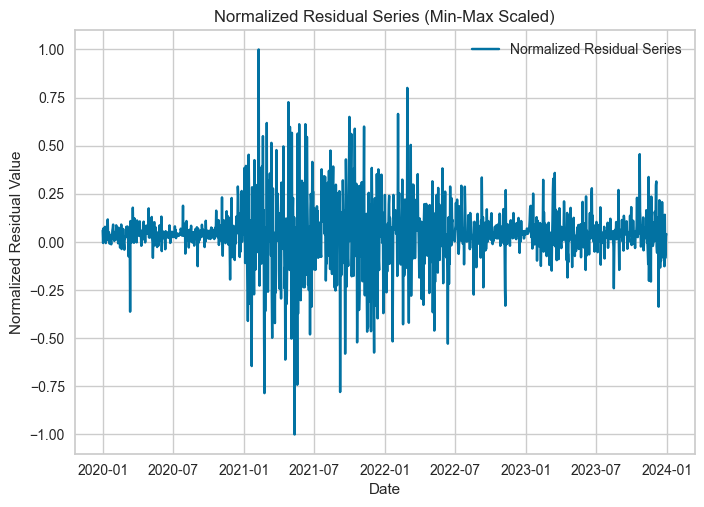

In [45]:
normalized_residuals_index_dt = normalized_residuals.index.to_timestamp()
plt.plot(normalized_residuals_index_dt, normalized_residuals, label='Normalized Residual Series')
plt.title('Normalized Residual Series (Min-Max Scaled)')
plt.xlabel('Date')
plt.ylabel('Normalized Residual Value')
plt.legend()
plt.show()


In [46]:
normalized_residuals.fillna(0, inplace=True) 

8: Performing manual lag selection on the in-sample data of residual series (1 = daily, 7 = weekly, 30 = monthly)

In [ ]:
# Preparing Data for ANN, Creating Lagged Features and Target
def create_lagged_features(series, lags):
    lagged_features = {}
    for lag in lags:
        lagged_features[f'lag_{lag}'] = series.shift(lag)
    lagged_df = pd.DataFrame(lagged_features)
    return lagged_df 

lags_to_use = [1, 7, 30] 

lagged_residual_features = create_lagged_features(normalized_residuals, lags_to_use)
lagged_residual_features.dropna(inplace=True) 

residual_target = normalized_residuals.reindex(lagged_residual_features.index)

X_train_ann = lagged_residual_features
y_train_ann = residual_target

X_train_ann_np = X_train_ann.values
y_train_ann_np = y_train_ann.values

In [55]:
# The Data Splitting for Validation 
X_train_ann_train, X_val_ann, y_train_ann_train, y_val_ann = train_test_split(
    X_train_ann, y_train_ann, test_size=0.2, shuffle=False
)

X_val_ann_np = X_val_ann.values  
y_val_ann_np = y_val_ann.values 
X_train_ann_train_np = X_train_ann_train.values 
y_train_ann_train_np = y_train_ann_train.values 

# Ensure that the Data Types are float32 
X_train_ann_train_np = X_train_ann_train_np.astype(np.float32) 
X_val_ann_np = X_val_ann_np.astype(np.float32) 
y_train_ann_train_np = y_train_ann_train_np.astype(np.float32) 
y_val_ann_np = y_val_ann_np.astype(np.float32)

In [56]:
# --- Manual Tuning Loop Code Block ---

neuron_options = [25, 50, 100]
epochs_options = [30, 50, 70]
batch_size_options = [16, 32, 64]

best_rmse = float('inf') 
best_params = None

for neurons in neuron_options:
    for epochs in epochs_options:
        for batch_size in batch_size_options:
            print(f"Trying: Neurons={neurons}, Epochs={epochs}, Batch Size={batch_size}")
            
            # Building an ANN model 
            ann_model = Sequential()
            ann_model.add(Dense(neurons, activation='relu', input_shape=(X_train_ann_train_np.shape[1],))) 
            ann_model.add(Dense(25, activation='relu'))
            ann_model.add(Dense(1))
            ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse') 
            
            # Train model
            ann_model.fit(X_train_ann_train_np, y_train_ann_train_np, epochs=epochs, batch_size=batch_size, verbose=0)
            
            print(f"NaNs in X_val_ann_np BEFORE prediction: {np.isnan(X_val_ann_np).any()}") 
            # Validate model
            validation_predictions = ann_model.predict(X_val_ann_np).flatten() 
            rmse = np.sqrt(mean_squared_error(y_val_ann_np, validation_predictions)) 

            print(f"  Validation RMSE: {rmse:.4f}")

            if rmse < best_rmse: 
                best_rmse = rmse
                best_params = {'neurons': neurons, 'epochs': epochs, 'batch_size': batch_size}

print("\nBest Hyperparameters found (based on Validation RMSE):")
print(best_params)
print(f"Best Validation RMSE: {best_rmse:.4f}")

Trying: Neurons=25, Epochs=30, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 441us/step


  Validation RMSE: 0.0915
Trying: Neurons=25, Epochs=30, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 946us/step


  Validation RMSE: 0.0902
Trying: Neurons=25, Epochs=30, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 387us/step


  Validation RMSE: 0.0903
Trying: Neurons=25, Epochs=50, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 595us/step


  Validation RMSE: 0.0914
Trying: Neurons=25, Epochs=50, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 446us/step


  Validation RMSE: 0.0907
Trying: Neurons=25, Epochs=50, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 353us/step


  Validation RMSE: 0.0904
Trying: Neurons=25, Epochs=70, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 389us/step


  Validation RMSE: 0.0906
Trying: Neurons=25, Epochs=70, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 458us/step


  Validation RMSE: 0.0916
Trying: Neurons=25, Epochs=70, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 428us/step


  Validation RMSE: 0.0918
Trying: Neurons=50, Epochs=30, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 392us/step


  Validation RMSE: 0.0911
Trying: Neurons=50, Epochs=30, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 368us/step


  Validation RMSE: 0.0911
Trying: Neurons=50, Epochs=30, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 358us/step


  Validation RMSE: 0.0909
Trying: Neurons=50, Epochs=50, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 417us/step


  Validation RMSE: 0.0910
Trying: Neurons=50, Epochs=50, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 396us/step


  Validation RMSE: 0.0947
Trying: Neurons=50, Epochs=50, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 387us/step


  Validation RMSE: 0.0915
Trying: Neurons=50, Epochs=70, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 391us/step


  Validation RMSE: 0.0936
Trying: Neurons=50, Epochs=70, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 405us/step


  Validation RMSE: 0.0939
Trying: Neurons=50, Epochs=70, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 764us/step


  Validation RMSE: 0.0925
Trying: Neurons=100, Epochs=30, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 412us/step


  Validation RMSE: 0.0910
Trying: Neurons=100, Epochs=30, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 398us/step


  Validation RMSE: 0.0909
Trying: Neurons=100, Epochs=30, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 439us/step


  Validation RMSE: 0.0904
Trying: Neurons=100, Epochs=50, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 469us/step


  Validation RMSE: 0.0907
Trying: Neurons=100, Epochs=50, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 391us/step


  Validation RMSE: 0.0953
Trying: Neurons=100, Epochs=50, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 411us/step


  Validation RMSE: 0.0916
Trying: Neurons=100, Epochs=70, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 471us/step


  Validation RMSE: 0.0925
Trying: Neurons=100, Epochs=70, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 408us/step


  Validation RMSE: 0.0925
Trying: Neurons=100, Epochs=70, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
9/9 [==============================] - 0s 416us/step
  Validation RMSE: 0.0935

Best Hyperparameters found (based on Validation RMSE):
{'neurons': 25, 'epochs': 30, 'batch_size': 32}
Best Validation RMSE: 0.0902


In [57]:
# Best Hyperparameters from Tuning 

best_neurons = 25
best_epochs = 30
best_batch_size = 32

# 1. Building the Final ANN Model with Best Hyperparameters
final_ann_model = Sequential()
final_ann_model.add(Dense(best_neurons, activation='relu', input_shape=(X_train_ann_np.shape[1],))) 
final_ann_model.add(Dense(25, activation='relu')) 
final_ann_model.add(Dense(1))

# 2. Compiling the Final ANN Model
optimizer = Adam(learning_rate=0.001) 
final_ann_model.compile(optimizer=optimizer, loss='mse')

# 3. Training the Final ANN Model
final_ann_model.fit(X_train_ann_np, y_train_ann_np, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# 4. Print Model Summary of the Final Model
final_ann_model.summary()

print("\nFinal ANN Model Retraining Complete (with Best Hyperparameters)!")

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 25)                100       
                                                                 
 dense_163 (Dense)           (None, 25)                650       
                                                                 
 dense_164 (Dense)           (None, 1)                 26        
                                                                 
Total params: 776
Trainable params: 776
Non-trainable params: 0
_________________________________________________________________

Final ANN Model Retraining Complete (with Best Hyperparameters)!


Obtaining In-Sample ANN Residual Predictions
10: Obtain predictions using ANN model
11: De-normalize the predictions to obtain the predictions for the second componente?


First 10 De-normalized In-Sample ANN Residual Predictions:
Date
2020-01-31     97.440498
2020-02-01    -16.971420
2020-02-02     55.675720
2020-02-03     38.515427
2020-02-04     69.838234
2020-02-05     50.269459
2020-02-06    163.190201
2020-02-07      7.431483
2020-02-08      6.759334
2020-02-09     92.466499
Freq: D, dtype: float32


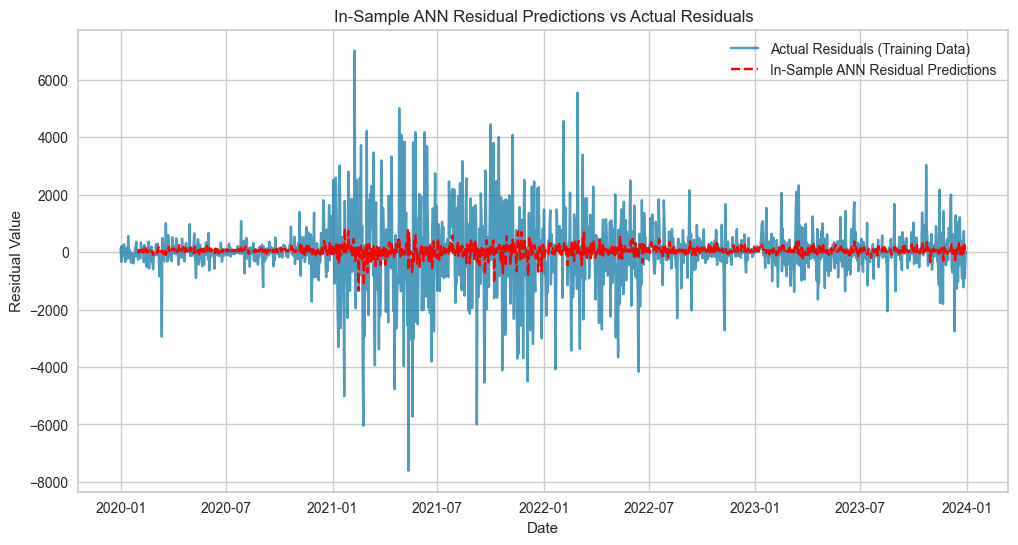

In [58]:
# 1. Generate In-Sample ANN Residual Predictions (Normalized)
ann_predictions_insample_normalized = final_ann_model.predict(X_train_ann_np, verbose=0).flatten()
ann_predictions_insample_normalized = pd.Series(ann_predictions_insample_normalized, index=X_train_ann.index)

# 2. De-normalize ANN Predictions (back to original residual scale)
ann_predictions_insample_denormalized = scaler_residuals.inverse_transform(ann_predictions_insample_normalized.values.reshape(-1, 1)).flatten()
ann_predictions_insample_denormalized = pd.Series(ann_predictions_insample_denormalized, index=ann_predictions_insample_normalized.index)

# 3. Print a sample of de-normalized in-sample ANN predictions
print("\nFirst 10 De-normalized In-Sample ANN Residual Predictions:")
print(ann_predictions_insample_denormalized.head(10))

# 4. Plotting In-Sample ANN Residual Predictions vs Actual Residuals 
plt.figure(figsize=(12, 6))
plt.plot(residuals.index.to_timestamp(), residuals, label='Actual Residuals (Training Data)', alpha=0.7) 
plt.plot(ann_predictions_insample_denormalized.index.to_timestamp(), ann_predictions_insample_denormalized, label='In-Sample ANN Residual Predictions', linestyle='--', color='red') 
plt.title('In-Sample ANN Residual Predictions vs Actual Residuals')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

Obtaining Hold-out ANN Residual Predictions

In [59]:
# 1. Prepare for Iterative Forecast - Get last training residuals as initial history
last_train_residuals_normalized = normalized_residuals.tail(max(lags_to_use)).values 
ann_predictions_holdout_normalized = [] 
current_residuals_history = list(last_train_residuals_normalized) 

# 2. Iterative (Recursive) Forecast Loop - for each step in forecast horizon (fh)
forecast_horizon = len(exp_btc.get_config('y_test')) 

for _ in range(forecast_horizon): # Iterate for each step in forecast horizon
    
    # a. Feature vector from current residual history
    feature_vector = np.array([current_residuals_history[-lag] for lag in lags_to_use]).reshape(1, -1)
    
    # b. Predict next residual (normalized) using trained ANN model
    next_residual_normalized = final_ann_model.predict(feature_vector, verbose=0).flatten()[0] 
    ann_predictions_holdout_normalized.append(next_residual_normalized) 
    
    # c. Update residual history for next iteration - append predicted residual and remove oldest
    current_residuals_history.append(next_residual_normalized) 
    current_residuals_history.pop(0) 

# 3. Convert ANN Hold-out Predictions to Pandas Series with Test Set Index
ann_predictions_holdout_normalized = pd.Series(ann_predictions_holdout_normalized, index=exp_btc.get_config('y_test').index)

# 4. De-normalize ANN Hold-out Predictions 
ann_predictions_holdout_denormalized = scaler_residuals.inverse_transform(np.array(ann_predictions_holdout_normalized).reshape(-1, 1)).flatten()
ann_predictions_holdout_denormalized = pd.Series(ann_predictions_holdout_denormalized, index=ann_predictions_holdout_normalized.index)

# 5. Print sample of de-normalized hold-out ANN residual predictions
print("\nFirst 10 De-normalized Hold-out ANN Residual Predictions:")
print(ann_predictions_holdout_denormalized.head(10))

# Obtain ETS Hold-out Predictions
ets_predictions_holdout = exp_btc.predict_model(hw_add_btc)

# Ensuring the index of ETS hold-out predictions is a DatetimeIndex for plotting
if isinstance(ets_predictions_holdout.index, pd.PeriodIndex):
    ets_predictions_holdout.index = ets_predictions_holdout.index.to_timestamp()


First 10 De-normalized Hold-out ANN Residual Predictions:
Date
2024-01-01     65.802536
2024-01-02    -80.825500
2024-01-03    -95.161148
2024-01-04    110.096802
2024-01-05     14.026649
2024-01-06     44.033550
2024-01-07    161.321686
2024-01-08     36.187637
2024-01-09     26.169336
2024-01-10    274.852264
Freq: D, dtype: float32


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,4.9294,4.3317,11263.4223,15170.8838,0.1520,0.1716,-0.0705


In [60]:
# Print summary statistics (min, max, mean, std) for actual test residuals
y_test_btc_datetime_index = y_test_btc.copy() # Created a copy to avoid modifying original y_test_btc
y_test_btc_datetime_index.index = y_test_btc_datetime_index.index.to_timestamp() 

actual_test_residuals_series = y_test_btc_datetime_index - ets_predictions_holdout['y_pred']

print("\nSummary Statistics - Actual Test Set Residuals (DatetimeIndex):")
print(actual_test_residuals_series.describe())

# Print summary statistics for de-normalized ANN hold-out predictions
print("\nSummary Statistics - De-normalized ANN Hold-out Predictions:")
print(ann_predictions_holdout_denormalized.describe())


Summary Statistics - Actual Test Set Residuals (DatetimeIndex):
count      366.000000
mean     10622.043542
std      10846.628576
min      -5916.407094
25%       2689.785970
50%       8279.612275
75%      16659.768514
max      42695.916250
dtype: float64

Summary Statistics - De-normalized ANN Hold-out Predictions:
count    366.000000
mean      89.442909
std       20.087099
min      -95.161148
25%       90.545845
50%       90.545898
75%       90.545898
max      274.852264
dtype: float64


In [61]:
print("\nHead of ets_predictions_holdout DataFrame:")
print(ets_predictions_holdout.head())
print("\nInfo of ets_predictions_holdout DataFrame:")
ets_predictions_holdout.info()


Head of ets_predictions_holdout DataFrame:
                y_pred
2024-01-01  42909.2491
2024-01-02  43779.1711
2024-01-03  43744.2098
2024-01-04  43393.9627
2024-01-05  43328.7622

Info of ets_predictions_holdout DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_pred  366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [62]:
print("\nHead of y_test_btc DataFrame:")
print(y_test_btc.head())
print("\nInfo of y_test_btc DataFrame:")
y_test_btc.info()



Head of y_test_btc DataFrame:
Date
2024-01-01    44167.332031
2024-01-02    44957.968750
2024-01-03    42848.175781
2024-01-04    44179.921875
2024-01-05    44162.691406
Freq: D, Name: Close, dtype: float64

Info of y_test_btc DataFrame:
<class 'pandas.core.series.Series'>
PeriodIndex: 366 entries, 2024-01-01 to 2024-12-31
Freq: D
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [63]:
# Re-run to obtain Hold-out (Test Set) Predictions from Best ETS Model
ets_predictions_holdout = exp_btc.predict_model(ht_btc) 

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,3.9898,3.1633,9116.4496,11078.9280,0.1303,0.1378,0.4291


In [64]:
print("Test Data BTC Head:")
print(out_sample_btc.head())

print("\nETS Predictions Holdout Head:")
print(ets_predictions_holdout.head())

Test Data BTC Head:
Date
2024-01-01    44167.332031
2024-01-02    44957.968750
2024-01-03    42848.175781
2024-01-04    44179.921875
2024-01-05    44162.691406
Freq: D, Name: Close, dtype: float64

ETS Predictions Holdout Head:
                y_pred
2024-01-01  42368.9046
2024-01-02  42472.6301
2024-01-03  42576.3557
2024-01-04  42680.0812
2024-01-05  42783.8067


In [65]:
# Calculate residuals: actual - predictions


residuals = in_sample_btc - in_sample_predictions_ht_btc 


Combine ETS and ANN Predictions for Final Hybrid Forecasts
12: Final predictions are obtained by combining the ETS predictions C] with ANN predictions@7.

In [66]:
# Get ETS hold-out predictions 
ets_predictions_holdout = exp_btc.predict_model(ht_btc)

# Combine ETS predictions and ANN residual predictions for final hybrid hold-out forecasts
final_predictions_holdout_hybrid = ets_predictions_holdout['y_pred'] + ann_predictions_holdout_denormalized

# Print the first few final hybrid hold-out forecasts
print("\nFirst 10 Final Hybrid Hold-out Forecasts:")
print(final_predictions_holdout_hybrid.head(10))

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,3.9898,3.1633,9116.4496,11078.9280,0.1303,0.1378,0.4291



First 10 Final Hybrid Hold-out Forecasts:
2024-01-01    42434.707136
2024-01-02    42391.804600
2024-01-03    42481.194552
2024-01-04    42790.178002
2024-01-05    42797.833349
2024-01-06    42931.565750
2024-01-07    43152.579386
2024-01-08    43131.170937
2024-01-09    43224.878136
2024-01-10    43577.286564
Freq: D, dtype: float64


In [67]:
def ts_metrics(y, y_hat):
   
    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_percentage_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    r2 = r2_score(y, y_hat)
    
    metrics = {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2,
    }
    
    # Print metrics with descriptions
    print("Time Series Model Evaluation Metrics:")
    print("-" * 40)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4%}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    return 

Evaluation metrics Hybrid Model Performance on Hold-out Set

In [68]:
print("\n--- Hybrid Model Evaluation Metrics (Hold-out Set) ---")
ts_metrics(exp_btc.get_config('y_test'), final_predictions_holdout_hybrid) 


--- Hybrid Model Evaluation Metrics (Hold-out Set) ---
Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 9095.6100
Mean Absolute Percentage Error (MAPE): 13.0063%
Root Mean Squared Error (RMSE): 11041.1778
R-squared (R²): 0.4330


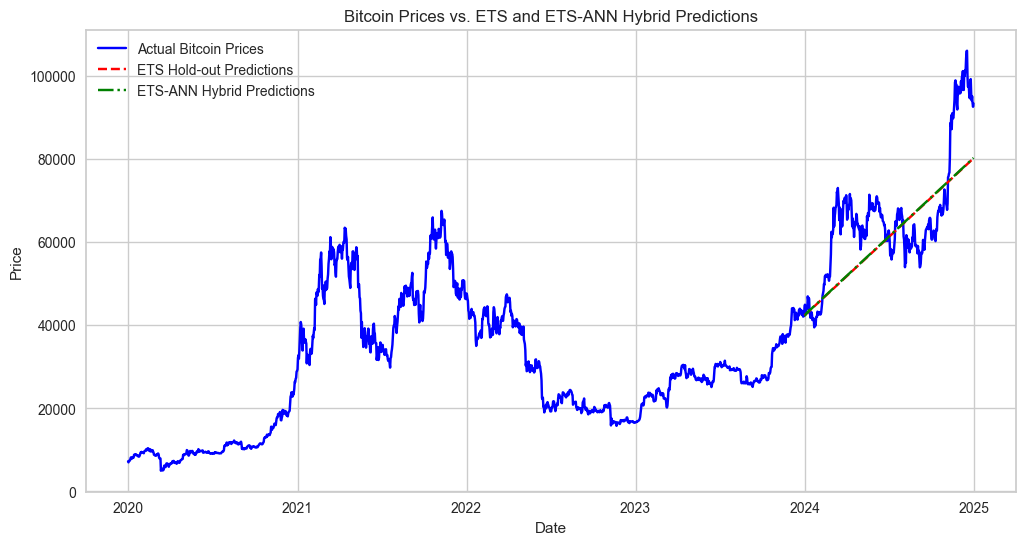

In [69]:
# Ensure correct index type for plotting
if isinstance(df_BTC.index, pd.PeriodIndex):
    df_BTC.index = df_BTC.index.to_timestamp()

if isinstance(ets_predictions_holdout.index, pd.PeriodIndex):
    ets_predictions_holdout.index = ets_predictions_holdout.index.to_timestamp()

# Ensure df_BTC is a DataFrame and contains the 'Close' column
if isinstance(df_BTC, pd.Series):
    df_BTC = df_BTC.to_frame(name='Close')

plt.figure(figsize=(12, 6))

# Plot Actual Bitcoin Prices (Full Data)
if isinstance(df_BTC, pd.DataFrame) and 'Close' in df_BTC.columns:
    plt.plot(df_BTC.index, df_BTC['Close'], label='Actual Bitcoin Prices', color='blue')
else:
    print("Error: 'Close' column not found in df_BTC DataFrame")

# Plot ETS Hold-out Predictions
if isinstance(ets_predictions_holdout, pd.DataFrame) and 'y_pred' in ets_predictions_holdout.columns:
    plt.plot(ets_predictions_holdout.index, ets_predictions_holdout['y_pred'], label='ETS Hold-out Predictions', color='red', linestyle='--')
else:
    print("Error: 'y_pred' column not found in ets_predictions_holdout DataFrame")

# Plot ETS-ANN Hybrid Predictions
if isinstance(final_predictions_holdout_hybrid, pd.Series):
    plt.plot(final_predictions_holdout_hybrid.index, final_predictions_holdout_hybrid, label='ETS-ANN Hybrid Predictions', color='green', linestyle='-.')
else:
    print("Error: final_predictions_holdout_hybrid is not a Series")

plt.title('Bitcoin Prices vs. ETS and ETS-ANN Hybrid Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

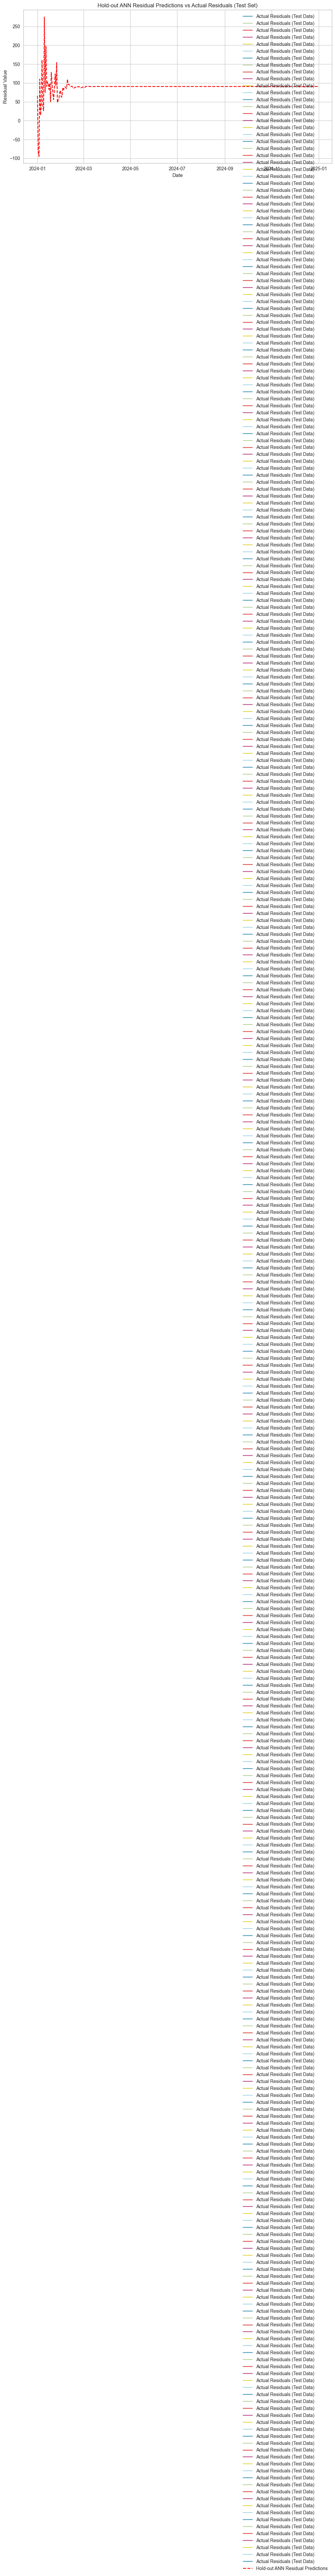

In [70]:
# 6. Plotting Hold-out ANN Residual Predictions vs Actual Residuals
plt.figure(figsize=(12, 6))
plt.plot(exp_btc.get_config('y_test').index.to_timestamp(), exp_btc.get_config('y_test') - ets_predictions_holdout, label='Actual Residuals (Test Data)', alpha=0.7) # Actual test residuals (calculated)
plt.plot(ann_predictions_holdout_denormalized.index.to_timestamp(), ann_predictions_holdout_denormalized, label='Hold-out ANN Residual Predictions', linestyle='--', color='red') # ANN holdout predictions
plt.title('Hold-out ANN Residual Predictions vs Actual Residuals (Test Set)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

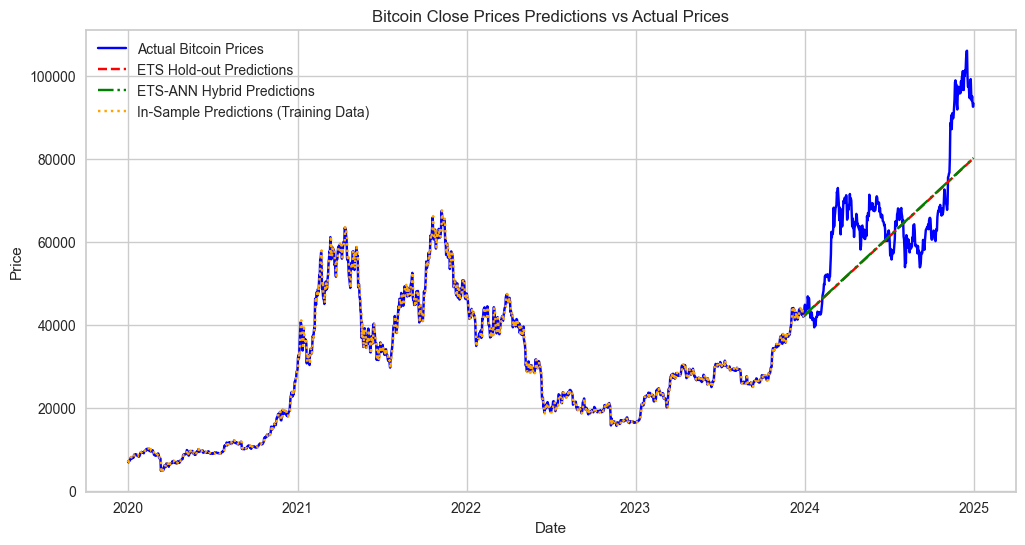

In [72]:
# Ensure correct index type for plotting
if isinstance(df_BTC.index, pd.PeriodIndex):
    df_BTC.index = df_BTC.index.to_timestamp()

if isinstance(ets_predictions_holdout.index, pd.PeriodIndex):
    ets_predictions_holdout.index = ets_predictions_holdout.index.to_timestamp()

# Ensure df_BTC is a DataFrame and contains the 'Close' column
if isinstance(df_BTC, pd.Series):
    df_BTC = df_BTC.to_frame(name='Close')

plt.figure(figsize=(12, 6))

# Plot Actual Bitcoin Prices (Full Data)
if isinstance(df_BTC, pd.DataFrame) and 'Close' in df_BTC.columns:
    plt.plot(df_BTC.index, df_BTC['Close'], label='Actual Bitcoin Prices', color='blue')
else:
    print("Error: 'Close' column not found in df_BTC DataFrame")

# Plot ETS Hold-out Predictions
if isinstance(ets_predictions_holdout, pd.DataFrame) and 'y_pred' in ets_predictions_holdout.columns:
    plt.plot(ets_predictions_holdout.index, ets_predictions_holdout['y_pred'], label='ETS Hold-out Predictions', color='red', linestyle='--')
else:
    print("Error: 'y_pred' column not found in ets_predictions_holdout DataFrame")

# Plot ETS-ANN Hybrid Predictions
if isinstance(final_predictions_holdout_hybrid, pd.Series):
    plt.plot(final_predictions_holdout_hybrid.index, final_predictions_holdout_hybrid, label='ETS-ANN Hybrid Predictions', color='green', linestyle='-.')
else:
    print("Error: final_predictions_holdout_hybrid is not a Series")

# Plot In-Sample Predictions (Training Data)
if isinstance(in_sample_predictions_ht_btc, pd.Series):
    plt.plot(in_sample_predictions_ht_btc.index.to_timestamp(), in_sample_predictions_ht_btc, label='In-Sample Predictions (Training Data)', color='orange', linestyle=':')
else:
    print("Error: in_sample_predictions_ht_btc is not a Series")

plt.title('Bitcoin Close Prices Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
# Show counts and date ranges for training, validation (if applicable), and test sets

# Training set
train_start_date = df_BTC.index[0]
train_end_date = df_BTC.index[len(y_train_btc) - 1]
train_count = len(y_train_btc)

# Test set
test_start_date = df_BTC.index[len(y_train_btc)]
test_end_date = df_BTC.index[len(df_BTC) - 1]
test_count = len(y_test_btc)

print(f"Training Set: {train_count} data points from {train_start_date} to {train_end_date}")
print(f"Test Set: {test_count} data points from {test_start_date} to {test_end_date}")

# If you have a validation set, include the following code

# Validation set (if used)
try:
    val_start_date = df_BTC.index[len(y_train_btc) - 60]
    val_end_date = df_BTC.index[len(y_train_btc) + len(y_val_ann) - 61]
    val_count = len(y_val_ann)

    print(f"Validation Set: {val_count} data points from {val_start_date} to {val_end_date}")
except NameError:
    print("No explicit validation set used in this script.")

Training Set: 1096 data points from 2020-01-01 00:00:00 to 2022-12-31 00:00:00
Test Set: 366 data points from 2023-01-01 00:00:00 to 2024-12-31 00:00:00
Validation Set: 287 data points from 2022-11-02 00:00:00 to 2023-08-15 00:00:00
